In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data_0 = pandas.read_csv('Data/hits.csv', index_col=0)

data_1 = data_0.copy()
data_1['Wy1'] = data_0['Wy1'].values + data_0.dist2Wire.values
data_1['Wy2'] = data_0['Wy2'].values + data_0.dist2Wire.values
data_2 = data_0.copy()
data_2['Wy1'] = data_0['Wy1'].values - data_0.dist2Wire.values
data_2['Wy2'] = data_0['Wy2'].values - data_0.dist2Wire.values
data = pandas.concat([data_1, data_2], axis=0)

data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.910845,0.910845,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.516483,-16.061389,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-26.749494,16.828378,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.435691,20.142180,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,0.426175,0.426175,2782.2500,2782.2500,2782.2500,0,0


# Tracks Reconstruction

In [310]:
from baseline import SimpleTemplateMatching
from hough import LinearHoughModel
from reconstruction import TracksReconstruction2D
from combination import Combinator


from metrics import TracksReconstractionMetrics, CombinatorQuality

### Tests

In [781]:
event = data[data.EventID == 126]
event12 = event[(event.StatNb <= 2)*(event.ViewNb != 1)*(event.ViewNb != 2)]

x = event12.Wz1.values
y = event12.Wy1.values

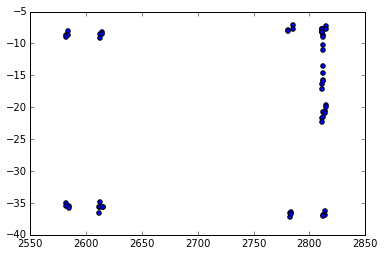

In [782]:
plt.scatter(x, y)
plt.show()

In [783]:
stm = SimpleTemplateMatching(n_max_hits=16, n_min_hits=4, window_width=0.9)

stm.fit(x, y)

labels = stm.labels_
tracks_params = stm.tracks_params_

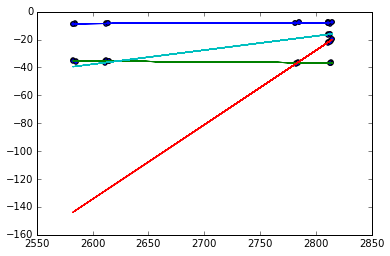

In [784]:
plt.scatter(x[labels != -1], y[labels != -1])
for params in tracks_params:
    plt.plot(x, x * params[0] + params[1])
plt.show()

In [735]:
x = x[labels != -1]
y = y[labels != -1]

In [736]:
class Retina2DTracker(object):
    
    def __init__(self, n_tracks, residuals_threshold, sigma_range, sigma_decay_rate, min_hits):
        
        self.n_tracks = n_tracks
        self.min_hits = min_hits
        self.sigma_range = sigma_range
        self.sigma_decay_rate = sigma_decay_rate
        self.residuals_threshold = residuals_threshold
        
        self.labels_ = None
        self.tracks_params_ = None
        
    def retina_func(self, track_prams, x, y, sigma):
    
        rs = track_prams[0] * x + track_prams[1] - y

        exps = numpy.exp(- (rs/sigma)**2)

        retina = exps.sum()

        return -retina
    
    def retina_grad(track_prams, x, y, sigma):
    
        rs = track_prams[0] * x + track_prams[1] - y

        exps = numpy.exp(- (rs/sigma)**2)

        dks = - 2.*rs / sigma**2 * exps * x
        dbs = - 2.*rs / sigma**2 * exps

        return -numpy.array([dks.sum(), dbs.sum()])
    
    def fit_one_track(self, x, y):
        
        sigma_min = self.sigma_range[0]
        sigma_max = self.sigma_range[1]
        
        sigma = sigma_max
        params = numpy.array([0, y[-1]])
        
        while sigma >= sigma_min:
            
            res = minimize(retina_func, params, args = (x, y, sigma), method='BFGS', jac=retina_grad, options={'gtol': 1e-6, 'disp': False})
            sigma *= self.sigma_decay_rate
            
            params = res.x
            
        return res.x
    
    def fit(self, x, y, sample_weight=None):
        
        labels = -1 * numpy.ones(len(x))
        tracks_params = []
        used = numpy.zeros(len(x))
        
        for track_id in range(self.n_tracks):
            
            x_track = x[labels == -1]
            y_track = y[labels == -1]
            
            if len(x_track) < self.min_hits or len(x_track) <= 0:
                break
            
            one_track_params = self.fit_one_track(x_track, y_track)
            tracks_params.append(one_track_params)
            
            dists = numpy.abs(one_track_params[0] * x + one_track_params[1] - y)
            
            if ((dists <= self.residuals_threshold)*1).sum() < self.min_hits:
                used[dists <= self.residuals_threshold] = 1
                continue
            
            labels[(dists <= self.residuals_threshold) & (used == 0)] = track_id
            used[dists <= self.residuals_threshold] = 1

            
        self.labels_ = labels
        self.tracks_params_ = numpy.array(tracks_params)

In [737]:
%%time
rt = Retina2DTracker(n_tracks=2, residuals_threshold=0.5, sigma_range=[1, 100], sigma_decay_rate=0.5, min_hits=2)

rt.fit(x, y)

labels = rt.labels_
tracks_params = rt.tracks_params_

CPU times: user 54 ms, sys: 2.6 ms, total: 56.6 ms
Wall time: 55.4 ms


In [738]:
labels

array([ 0.,  0.,  0.,  1., -1.,  1., -1., -1.,  0., -1., -1.,  1., -1.,
        0., -1., -1., -1., -1.,  1., -1.,  0., -1., -1., -1.,  0.,  0.,
       -1., -1.,  0.,  0.,  0., -1.,  0.,  1., -1.,  1., -1., -1., -1.,
        0., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  0.,  0.,
        0., -1., -1., -1.])

In [739]:
tracks_params

array([[  5.05421486e-02,   6.57333273e+01],
       [  5.97975942e-01,  -1.48132811e+03]])

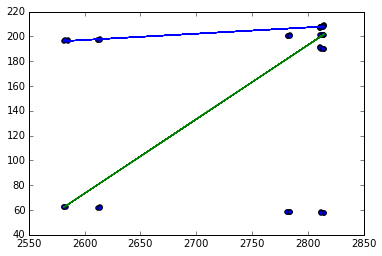

In [740]:
plt.scatter(x, y)
n = 1
plt.plot(x, tracks_params[0][0] * x + tracks_params[0][1])
plt.plot(x, tracks_params[n][0] * x + tracks_params[n][1])
plt.show()

In [741]:
def retina_func(track_prams, x, y, sigma):
    
    rs = track_prams[0] * x + track_prams[1] - y
    
    exps = numpy.exp(- (rs/sigma)**2)
    
    retina = exps.sum()
    
    return -retina

def retina_grad(track_prams, x, y, sigma):
    
    rs = track_prams[0] * x + track_prams[1] - y
    
    exps = numpy.exp(- (rs/sigma)**2)
    
    dks = - 2.*rs / sigma**2 * exps * x
    dbs = - 2.*rs / sigma**2 * exps
    
    return -numpy.array([dks.sum(), dbs.sum()])

In [645]:
sigma = 0.5

N = 200
ks = numpy.linspace(-0.2 ,0.2, N)
bs = numpy.linspace(-600 ,600, N)

retina = numpy.zeros((N, N))

for i in range(N):
    for j in range(N):
        
        retina[i, j] = retina_func([ks[i], bs[j]], x, y, sigma)

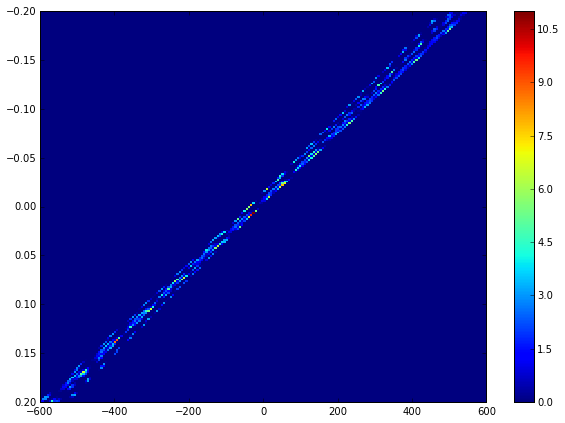

In [646]:
plt.figure(figsize=(10,7))
plt.imshow(-retina, interpolation='nearest', aspect='auto', extent=(bs.min(), bs.max(), ks.max(), ks.min()))
plt.colorbar()
plt.show()

In [569]:
from scipy.optimize import minimize

In [570]:
x1 = x[0]
x2 = x[-1]
y1 = y[0]
y2 = y[-1]

k0 = (y2 - y1) / (x2 - x1)
b0 = y1 - k0 * x1

In [571]:
%%time
x0 = numpy.array([k0, b0])
sigma = 100
res = minimize(retina_func, x0, args = (x, y, sigma), method='BFGS', jac=retina_grad, options={'gtol': 1e-6, 'disp': True})

x0 = res.x
sigma = 10
res = minimize(retina_func, x0, args = (x, y, sigma), method='BFGS', jac=retina_grad, options={'gtol': 1e-6, 'disp': True})

x0 = res.x
sigma = 1
res = minimize(retina_func, x0, args = (x, y, sigma), method='BFGS', jac=retina_grad, options={'gtol': 1e-6, 'disp': True})

Optimization terminated successfully.
         Current function value: -80.645650
         Iterations: 23
         Function evaluations: 35
         Gradient evaluations: 35
Optimization terminated successfully.
         Current function value: -49.653391
         Iterations: 23
         Function evaluations: 48
         Gradient evaluations: 48
Optimization terminated successfully.
         Current function value: -20.276269
         Iterations: 13
         Function evaluations: 37
         Gradient evaluations: 37
CPU times: user 13.7 ms, sys: 3.49 ms, total: 17.2 ms
Wall time: 14.3 ms


In [572]:
res.x

array([  1.97043688e-02,   1.45808910e+02])

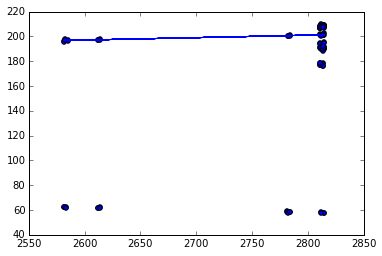

In [573]:
plt.scatter(x, y)
plt.plot(x, res.x[0] * x + res.x[1])
plt.show()

In [346]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency(eff_threshold=0.3)
hme.fit(event12.Label.values, labels)

hme.recognition_efficiency_

1.0

In [347]:
tracks_params

array([[  2.89437838e-03,   2.74439732e+01],
       [  2.14522683e-03,   2.41357784e+01]])

In [348]:
labels

array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1., -1.,  0.,  1.,
        1., -1.,  1.,  0., -1., -1., -1.,  1.,  0.,  1.,  0.,  0.,  1.,
        1.,  0., -1., -1., -1.,  0.,  1.,  0.])

In [349]:
event12.Label.values

array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,
        1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.])

### Tracks Reconstruction

In [504]:
%%time
from multiprocessing import Pool
from utils import merge_dicts

event_ids = numpy.unique(data.EventID.values)
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = Retina2DTracker(n_tracks=2, residuals_threshold=0.5, sigma_range=[1, 100], sigma_decay_rate=0.5, min_hits=2)
    stm_stereo = Retina2DTracker(n_tracks=1, residuals_threshold=15, sigma_range=[20, 1000], sigma_decay_rate=0.5, min_hits=2)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 388 ms, sys: 311 ms, total: 698 ms
Wall time: 55.3 s


In [505]:
#tracks_reconstruction(2)

In [506]:
%%time

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in tracks.keys():
    
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = None# 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = None# 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    labels12 = tracks[event_id]['labels12']
    tracks_params12 = tracks[event_id]['params12']
    labels34 = tracks[event_id]['labels34']
    tracks_params34 = tracks[event_id]['params34']
    
    # Select model for the tracks reconstruction
    # stm_y = LinearHoughModel(k_params=(-0.2, 0.2, 0.0004), b_params=(-800, 800, 1.6), min_hits=4, multiplier=2)
    # stm_stereo = LinearHoughModel(k_params=(-0.2, 0.2, 0.005), b_params=(-800, 800, 10), min_hits=4, multiplier=2)
    
    
    # Tracks reconstruction before the magnet
    # tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d12.fit(event12, weights12)
    
    # labels12 = tr2d12.labels_
    # tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    # tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    # tr2d34.fit(event34, weights34)
    
    # labels34 = tr2d34.labels_
    # tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
        
    
    # Combination of the tracks before and after the magnet
    comb = Combinator(dy_max=2, dx_max=20)
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_true)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_y_ == 1)*1, 
                                                     (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_y_ == 1)*1, 
                                                     (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()


CPU times: user 18.5 s, sys: 645 ms, total: 19.1 s
Wall time: 18.8 s


In [507]:
combinations_quality.head(10)

,EventID,RecoEff,GhostRate,CloneRate,NCombined
0,4097,1.0,0,0,2
1,2,1.0,0,0,2
2,4267,1.0,0,0,2
3,7,1.0,0,0,2
4,4453,1.0,0,0,2
5,3081,0.5,0,0,1
6,10,0.5,0,0,1
7,2059,1.0,0,0,2
8,1036,1.0,0,0,2
9,3085,0.5,0,0,1


In [508]:
(combinations_quality.head(10).RecoEff.values == 1).sum()

7

In [509]:
tracks_metrics_before_stereo.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1.0,0,0.0
1,2,0.975000,1.0,0,0.0
2,4267,1.000000,1.0,0,0.0
3,7,0.847826,1.0,0,0.0
4,4453,1.000000,1.0,0,0.0
5,3081,1.000000,1.0,0,0.0
6,10,0.785714,0.5,0,0.5
7,2059,1.000000,1.0,0,0.0
8,1036,1.000000,1.0,0,0.0
9,3085,0.500000,0.5,0,0.5


In [510]:
tracks_metrics_before_y.head(10)

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
0,4097,1.000000,1,0,0
1,2,1.000000,1,0,0
2,4267,1.000000,1,0,0
3,7,1.000000,1,0,0
4,4453,1.000000,1,0,0
5,3081,1.000000,1,0,0
6,10,0.750000,1,0,0
7,2059,1.000000,1,0,0
8,1036,0.916667,1,0,0
9,3085,0.759259,1,0,0


In [528]:
tracks_metrics_before_y[tracks_metrics_before_y.RecoEff != 1]

,EventID,AvgEff,RecoEff,GhostRate,CloneRate
24,3110,0.750000,0.5,0.0,0.5
58,3161,0.812500,0.0,1.0,0.0
82,3946,0.500000,0.5,0.0,0.5
83,126,0.466667,0.0,1.0,0.0
102,1180,0.687500,0.5,0.5,0.0
122,2232,0.612500,0.5,0.5,0.0
163,381,0.714286,0.5,0.0,0.0
182,2263,0.535714,0.5,0.0,0.0
200,294,0.550000,0.5,0.0,0.5
203,3369,0.583333,0.5,0.0,0.5


# Quality

# Stations 1&2

### Y-views

In [511]:
tracks_metrics_before_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.968001
RecoEff         0.965672
GhostRate       0.014179
CloneRate       0.017910
dtype: float64

### Stereo-views

In [512]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.957177
RecoEff         0.964925
GhostRate       0.014925
CloneRate       0.019403
dtype: float64

### Stations 1&2

In [513]:
tracks_metrics_before_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.947540
RecoEff         0.974627
GhostRate       0.012687
CloneRate       0.012687
dtype: float64

### Track efficiency

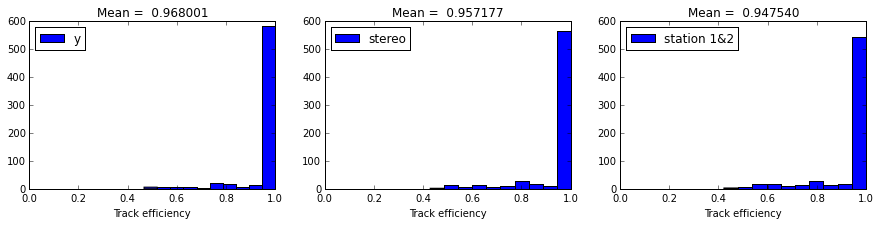

In [514]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

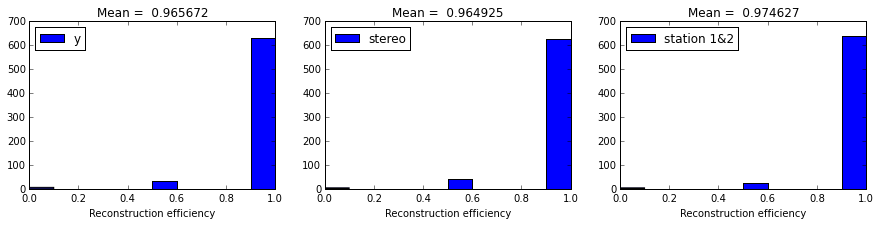

In [515]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [516]:
tracks_metrics_after_y.mean(axis=0)

EventID      2555.164179
AvgEff          0.957109
RecoEff         0.937313
GhostRate       0.046269
CloneRate       0.020149
dtype: float64

### Stereo-views

In [517]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2555.164179
AvgEff          0.944774
RecoEff         0.926119
GhostRate       0.048507
CloneRate       0.024627
dtype: float64

### Station 3&4

In [518]:
tracks_metrics_after_all.mean(axis=0)

EventID      2555.164179
AvgEff          0.926474
RecoEff         0.941791
GhostRate       0.041791
CloneRate       0.015672
dtype: float64

### Tracks efficiency

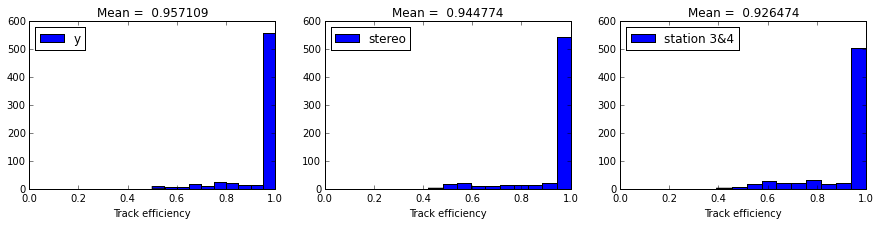

In [519]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

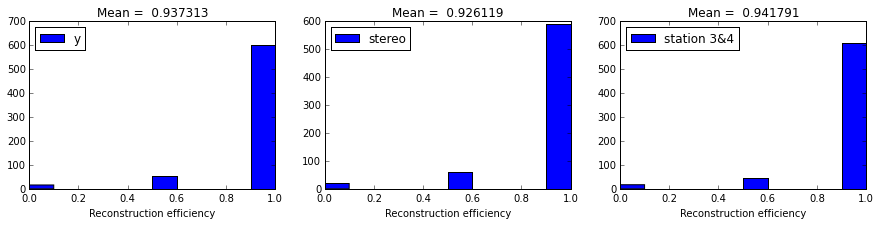

In [520]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [521]:
combinations_quality.mean(axis=0)

EventID      2555.164179
RecoEff         0.720896
GhostRate       0.003731
CloneRate       0.000000
NCombined       1.441791
dtype: float64

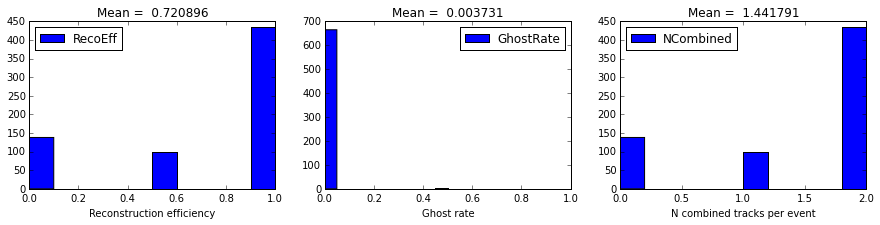

In [522]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

64.6268656716


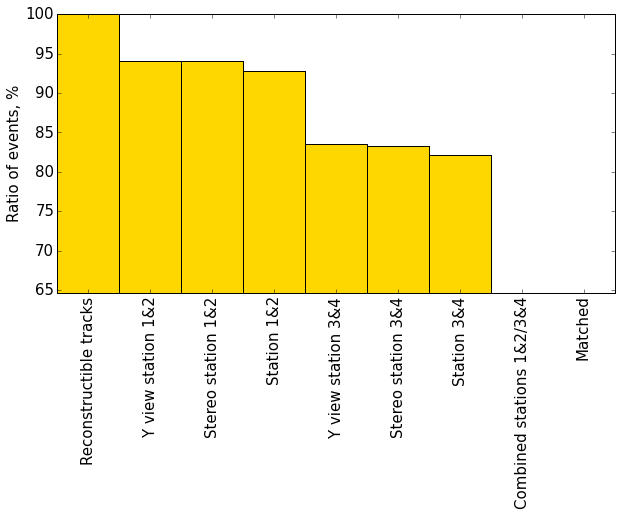

In [523]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [524]:
bar_values

array([ 100.        ,   94.02985075,   94.02985075,   92.8358209 ,
         83.58208955,   83.28358209,   82.08955224,   64.62686567,
         64.62686567])

# Momentum

In [525]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

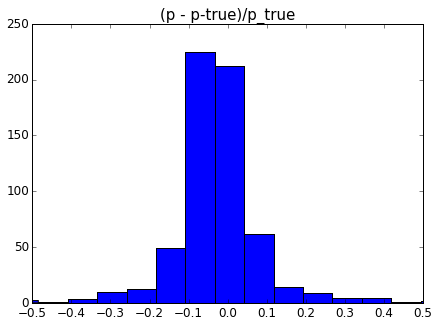

In [526]:
plt.figure(figsize=(7, 5))
plt.hist(p_err[numpy.isfinite(p_err)], bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()

In [527]:
len(p_err) - len(p_err[numpy.isfinite(p_err)])

5